## Laboratorium 7.2


## Przepływ optyczny i śledzenie obiektów

### Wprowadzenie

Metodę przepływu optycznego (między innymi) można stosować również do śledzenia obiektów. Zazwyczaj wykorzystuje się w tym celu metody rzadkie połączone ze znanymi już nam metodami detekcji punktów zainteresowania. Procedura przebiega podobnie jak w przypadku gęstego przepływu (tzn. operujemy na parze klatek w skali szarości, znajdujemy wektory przesunięć), z tą różnicą że obliczanie przepływu zachodzi wyłącznie dla interesujących nas punktów - a zatem musimy znać ich położenia, aby zainicjować proces. Można sobie wyobrazić różne sposoby zlokalizowania punktów kluczowych, w zależności od konkretnego zastosowania i założeń: być może np. pipeline do przetwarzania rozpoczyna się od zlokalizowania jakichś obiektów, być może z góry wiemy, gdzie obiekty się znajdują.

W OpenCV podstawową metodą do obliczania przepływu dla zbioru punktów jest metoda Lucasa-Kanade, zaimplementowana w funkcji [`cv2.calcOpticalFlowPyrLK`](https://docs.opencv.org/3.4/dc/d6b/group__video__track.html#ga473e4b886d0bcc6b65831eb88ed93323). Podobnie jak w metodzie Farnebacka, argument `nextPts` ustawiamy na `None` (chyba, że chcemy zainicjować rozwiązanie już znanymi położeniami punktów, ale w praktyce z reguły nie będziemy mieli takiej wygody), argumenty `status` i `err` pomijamy zupełnie. W odróżnieniu od Farnebacka, wynikiem są absolutne położenia punktów na drugiej klatce (a nie wektory przesunięć). Dodatkowo otrzymujemy też wektor `status` informujący dla każdego punktu, czy udało się go odnaleźć, oraz `err` mierzący jakąś miarę błędu wizualnego pomiędzy fragmentem obrazu zawierającym dany punkt kluczowy.

Do inicjalizacji rozwiązania można wykorzystać znane nam metody znajdowania punktów kluczowych, albo opartą o detektor Harrisa funkcję [`cv2.goodFeaturesToTrack`](https://docs.opencv.org/3.4/dd/d1a/group__imgproc__feature.html#ga1d6bb77486c8f92d79c8793ad995d541) - jest nieco prostsza w użyciu, bo na wyjściu otrzymujemy po prostu macierz `np.float32` o wymiarach $Nx1x2$ zawierającą koordynaty znalezionych punktów.

Oczywiście, śledzenie obiektów oparte o jednorazową inicjalizację jest narażone na błędy: zniknięcie lub tymczasowe zasłonięcie śledzonego obiektu, czy choćby zmiana jego wyglądu (np. wskutek pojawienia się cienia) mogą spowodować, że przepływ nie zostanie obliczony. Może być też pożądana możliwość śledzenia ciągłego z uwzględnieniem pojawiania się nowych obiektów (np. monitorowanie CCTV). W takich sytuacjach konieczne jest regularne odświeżanie inicjalizacji, tj. ponowne wykrycie interesujących obiektów. To z kolei prowadzi do kolejnego problemu: jeżeli interesuje nas cała historia ruchu danych obiektów, przy czym do pewnego momentu ich lokalizacje uzyskiwaliśmy za pomocą przepływu optycznego, a w pewnym momencie wykonaliśmy ponowną detekcję - to jak powiązać jedno z drugim, by zapewnić ciągłość lokalizacji? To zagadnienie nie będzie jednak centralne na laboratorium.

---

In [1]:
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

### Zadanie 1

#### Zadanie 1a

Dany jest plik `amsterdam47.mp4` przedstawiający zapis ruchu na skrzyżowaniu. Uzupełnij podstawową pętlę analizy wideo o śledzenie obiektów: inicjalizację i wykorzystanie przepływu optycznego do aktualizacji ich położenia. Celem jest pozyskanie pełnej trajektorii obiektów, tak aby można było ją narysować (np. [`cv2.polylines`](https://docs.opencv.org/3.4/d6/d6e/group__imgproc__draw.html#gaa3c25f9fb764b6bef791bf034f6e26f5)) tudzież przetwarzać dalej.

Wynik zaprezentuj w postaci graficznej (narysowane trajektorie znalezionych obiektów). Niekoniecznie musisz przetwarzać cały materiał wideo - zwróć uwagę, że pojazdy znikają poza klatką, uniemożliwiając ich dalsze śledzenie.

In [9]:
from tqdm import tqdm


def base_loop(source, n_frames, max_corners):
    frame1 = None
    status, start_frame = source.read()
    frame2 = cv2.cvtColor(start_frame, cv2.COLOR_BGR2GRAY)
    # inicjalizacja
    prev_points = cv2.goodFeaturesToTrack(
        frame2, maxCorners=max_corners, qualityLevel=0.1, minDistance=10)
    frames_processed = 0
    mask = np.zeros_like(start_frame)
    p_bar = tqdm(total=n_frames+1)
    history_pt = [prev_points]
    while status and frames_processed < n_frames:
        frame1 = frame2
        status, frame2 = source.read()
        if not status:
            break
        frame2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
        p_bar.update(1)
        frames_processed += 1
        # przetwarzanie
        new_points, opt_status, err = cv2.calcOpticalFlowPyrLK(
            frame1, frame2, prev_points, None)
        history_pt.append(new_points)
        prev_points = new_points.reshape(-1, 1, 2)
    return start_frame, history_pt


def calc_flows(source: cv2.VideoCapture, n_frames=10, max_corners=0):
    start_frame, history_pt = base_loop(source, n_frames, max_corners)
    history_pt = reshape_history(history_pt)
    draw_flow(start_frame, history_pt)


def draw_flow(start_frame, history_pt):
    color = np.random.randint(0, 255, (history_pt.shape[0], 3))
    img = start_frame
    for i in range(color.shape[0]):
        c = color[i].tolist()
        img = cv2.polylines(img, [history_pt[i]], False, color=c, thickness=2)
    plt.imshow(img)
    plt.show()


def reshape_history(history_pt):
    np_array = np.array(history_pt)
    np_array = np.swapaxes(np_array, 0, 1)
    np_array = np.squeeze(np_array).astype(int)
    return np_array


def skip_frames(movie, n_frames):
    for _ in range(n_frames):
        movie.read()
    return movie


def get_video(source: str):
    return cv2.VideoCapture(source)


In [70]:
# def baseLoop(source: cv2.VideoCapture, n_frames=10, max_corners=0):
#     frame1 = None
#     status, start_frame = source.read()
#     frame2 = cv2.cvtColor(start_frame, cv2.COLOR_BGR2GRAY)
#     # inicjalizacja
#     prev_points = cv2.goodFeaturesToTrack(
#         frame2, maxCorners=max_corners, qualityLevel=0.1, minDistance=10)
#     frames_processed = 0
#     color = np.random.randint(0, 255, (prev_points.shape[0], 3))
#     mask = np.zeros_like(start_frame)
#     p_bar = tqdm(total=n_frames+1)
#     while status and frames_processed < n_frames:
#         frame1 = frame2
#         status, frame2 = source.read()
#         if not status:
#             print('no more frames')
#             break
#         frame2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
#         p_bar.update(1)
#         frames_processed += 1
#         # przetwarzanie
#         new_points, opt_status, err = cv2.calcOpticalFlowPyrLK(
#             frame1, frame2, prev_points, None)
#         for i, (new, old) in enumerate(zip(new_points, prev_points)):
#             if opt_status[i] == 1:
#                 a, b = new.ravel()
#                 c, d = old.ravel()
#                 mask = cv2.line(mask, (int(a), int(b)),
#                                 (int(c), int(d)), color[i].tolist(), 2)
#         prev_points = new_points.reshape(-1, 1, 2)
#     img = cv2.add(start_frame, mask)
#     plt.imshow(img)
#     plt.show()

 93%|█████████▎| 362/391 [00:00<00:00, 717.16it/s]


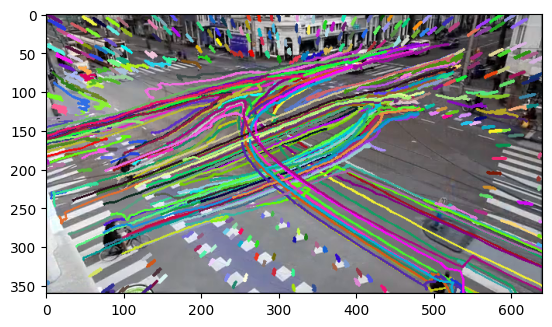

 93%|█████████▎| 362/391 [00:00<00:00, 1132.43it/s]


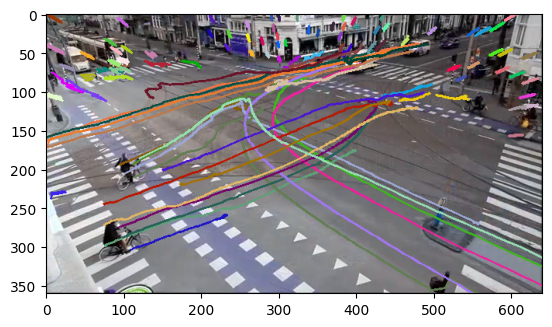

 93%|█████████▎| 362/391 [00:00<00:00, 1190.83it/s]


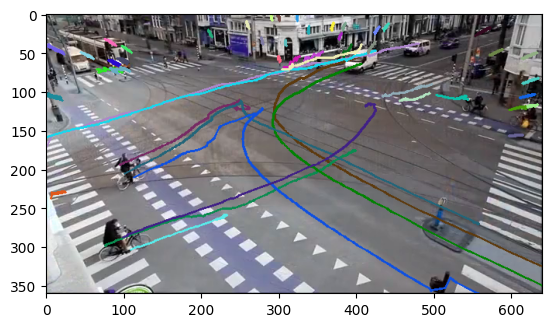

In [10]:
calc_flows(get_video('data/amsterdam47.mp4'), n_frames=13*30)
calc_flows(get_video('data/amsterdam47.mp4'), n_frames=13*30, max_corners=100)
calc_flows(get_video('data/amsterdam47.mp4'), n_frames=13*30, max_corners=50)

#### Zadanie 1b

Powtórz poprzednie doświadczenie na różnych fragmentach materiału źródłowego. Kiedy i w jaki sposób metoda zawodzi?

 52%|█████▏    | 205/391 [00:00<00:00, 1033.50it/s]

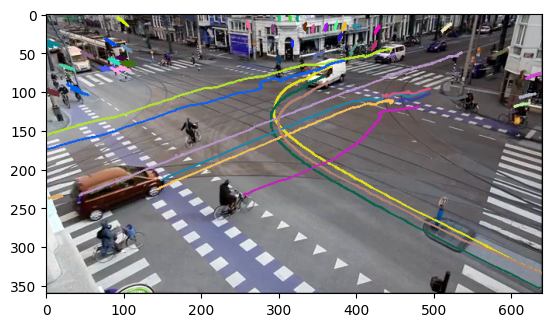

 31%|███       | 120/391 [00:00<00:00, 1199.21it/s]

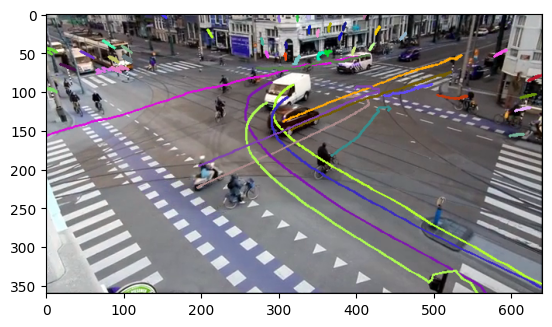

 31%|███▏      | 123/391 [00:00<00:00, 1227.02it/s]

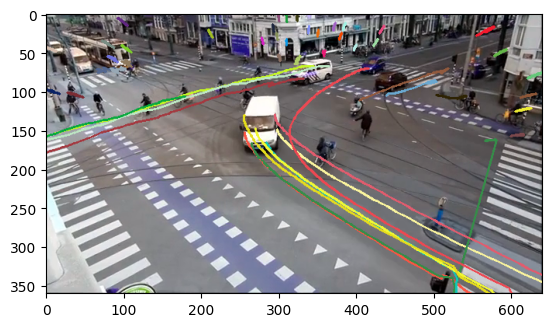

 30%|██▉       | 116/391 [00:00<00:00, 1156.52it/s]

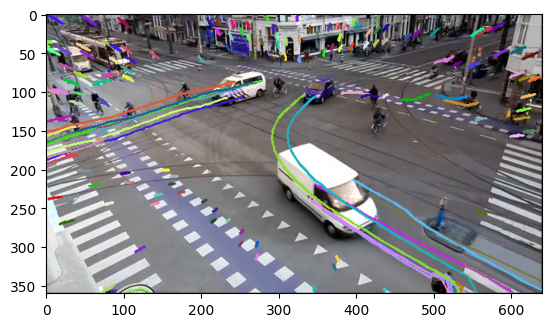

  0%|          | 0/391 [00:00<?, ?it/s]

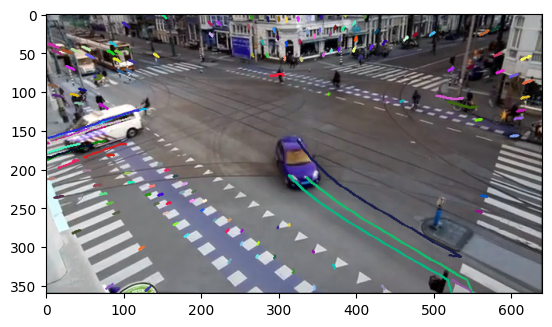

 16%|█▌        | 62/391 [00:00<00:01, 316.05it/s]


In [4]:
calc_flows(skip_frames(get_video('data/amsterdam47.mp4'), n_frames=30*2), n_frames=13*30, max_corners=50)
calc_flows(skip_frames(get_video('data/amsterdam47.mp4'), n_frames=30*4), n_frames=13*30, max_corners=50)
calc_flows(skip_frames(get_video('data/amsterdam47.mp4'), n_frames=30*6), n_frames=13*30, max_corners=50)
calc_flows(skip_frames(get_video('data/amsterdam47.mp4'), n_frames=30*8), n_frames=13*30, max_corners=150)
calc_flows(skip_frames(get_video('data/amsterdam47.mp4'), n_frames=30*10), n_frames=13*30, max_corners=150)


Komentarz 1:

Przybliżenia i oddalenia mogą wpływać na kształt trajektorii. Widać to przy śladzie białego pojazdu, gdzie jeden z punktów trochę się przesuwa. Nie jest to jednak tak duże zjawisko, jak można się spodziewać i raczej nie występuje w centrum obrazu (im bliżej centrum obiektywu, tym przesunięcia będą mniejsze). Tak więc efekt może być zauważalny, ale nie jest bardzo widoczny i nie powinien być wielkim problemem.

Występuje również czasem problem przejmowania punktów obiektu.

### Zadanie 2

Wykorzystując historię położenia poszczególnych obiektów, zidentyfikuj punkty należące do tła i odfiltruj je ze zbioru śledzonych obiektów.  
*Jeśli starczy czasu:* zidentyfikuj punkty należące do tych samych obiektów (tj. poruszające się w ten sam sposób).

 93%|█████████▎| 362/391 [00:00<00:00, 682.25it/s]


(380, 363, 2)
(380,)


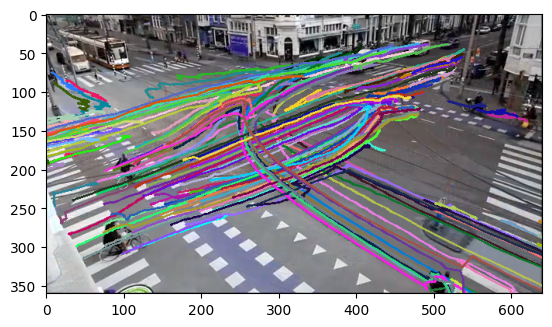

 93%|█████████▎| 362/391 [00:00<00:00, 722.44it/s]


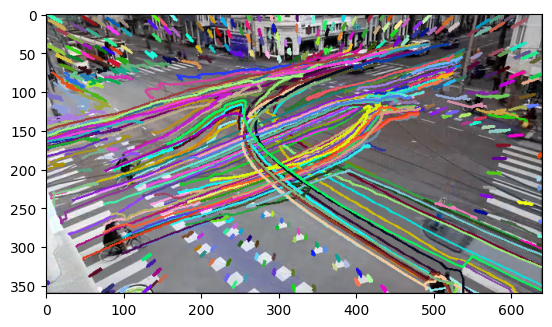

 31%|███       | 122/391 [00:00<00:00, 1021.83it/s]


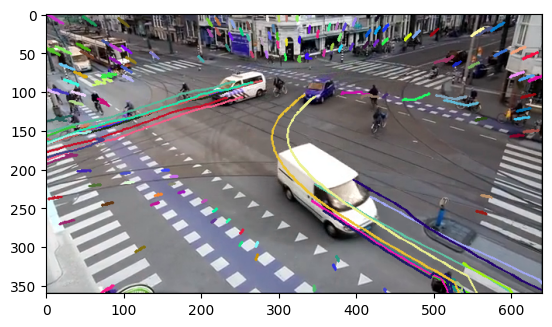

 31%|███       | 122/391 [00:00<00:00, 918.25it/s]


(150, 123, 2)
(150,)


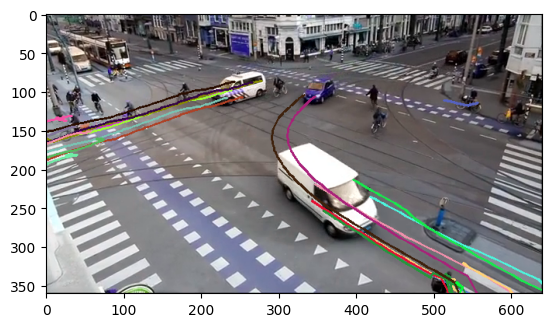

 16%|█▌        | 62/391 [00:00<00:00, 1171.17it/s]


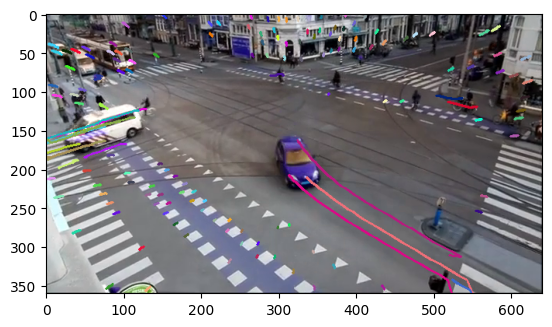

 16%|█▌        | 62/391 [00:00<00:00, 1238.63it/s]

(150, 63, 2)
(150,)


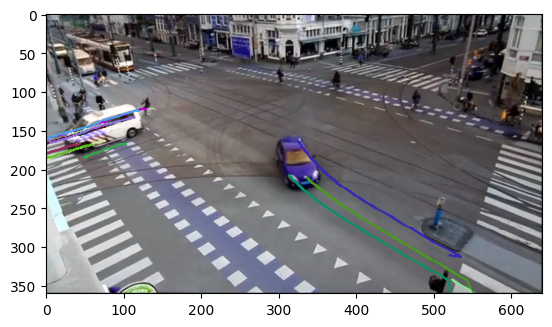

In [22]:
def calc_moving_flows(source: cv2.VideoCapture, n_frames=10, max_corners=0):
    start_frame, history_pt = base_loop(source, n_frames, max_corners)
    history_pt = reshape_history(history_pt)
    history_pt = filter_not_moving(history_pt)
    draw_flow(start_frame, history_pt)
    
def filter_not_moving(history_pt: np.ndarray, threshold=50)-> np.ndarray:
    print(history_pt.shape)
    maxes = np.max(history_pt, axis=1)
    mins = np.min(history_pt, axis=1)
    manhattan = np.sum(np.abs(maxes - mins), axis=1)
    print(manhattan.shape)
    idx = manhattan > threshold
    return history_pt[idx]

calc_moving_flows(get_video('data/amsterdam47.mp4'), n_frames=13*30)
calc_flows(get_video('data/amsterdam47.mp4'), n_frames=13*30)


calc_flows(skip_frames(get_video('data/amsterdam47.mp4'), n_frames=30*8), n_frames=13*30, max_corners=150)
calc_moving_flows(skip_frames(get_video('data/amsterdam47.mp4'), n_frames=30*8), n_frames=13*30, max_corners=150)
calc_flows(skip_frames(get_video('data/amsterdam47.mp4'), n_frames=30*10), n_frames=13*30, max_corners=150)
calc_moving_flows(skip_frames(get_video('data/amsterdam47.mp4'), n_frames=30*10), n_frames=13*30, max_corners=150)

---

### Zadanie ekstra

Rozszerz rozwiązanie z zadania 1 o możliwość śledzenia nowych obiektów pojawiających się w polu widzenia. Zadbaj o to, by ponowna detekcja punktów zainteresowania nie tworzyła duplikatów obiektów, które już są znane i śledzone.